In [12]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

In [13]:
data = np.genfromtxt('winequality-white.csv',delimiter=';')[1:]
print(data.shape)

(4898, 12)


In [14]:
X = data[:,:11]
y = data[:,11]
print(X.shape, y.shape)

(4898, 11) (4898,)


In [15]:
def normalize(X):
    X_flat = flatten(X)
    mu = X_flat.mean(axis=0)
    return [x - mu for x in X]
def flatten(X):
    X_flat = []

    for x in X:
        X_flat += list(x)

    return np.array(X_flat)

In [16]:
class ModelCheckpoint:
    def __init__(self, metric_fn, data_generator, num_sampled=10000):
        self.best_model = None
        self.best_metric = -float("inf")
        self.metric_fn = metric_fn
        self.num_sampled = num_sampled
        self.data_generator = data_generator
    
    def __call__(self, model):
        X_val, y_val = self.data_generator(self.num_sampled)
        metric = self.metric_fn(y_val, model.predict(X_val))
        
        if metric > self.best_metric:
            self.best_metric, self.best_model = metric, model   
            print("[ModelCheckpoint] New best model with %.3f validation accuracy" % metric)
        else:
            print("validation: %.3f accuracy" % metric)

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
X = normalize(X)
model = LogisticRegression(fit_intercept=False)
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
import random as rand
subsets = []
for i in range(100):        
    subsets.append(rand.sample(list(data), 10))
subsets = np.asarray(subsets)
subsets.shape

(100, 10, 12)

In [20]:
# Detailed in the paper
def svm_loss(preds, ys, delta=0):
    correct = ys.argmax()
    score_correct = preds[correct]
    
    loss = 0
    
    for i, pred in enumerate(preds):
        loss += max(0, pred + delta - score_correct)            
            
    return loss

In [21]:
model2 = LogisticRegression(fit_intercept=False,C=2, penalty='l2')
model2.fit(X, y)

def my_loss(preds, ys, delta = 0):
    correct = ys.argmax()
    score_correct = preds[correct]

    loss = 0
    for i, pred in enumerate(preds):
        loss += max(0, pred + delta - score_correct)
    return loss

Computing losses...


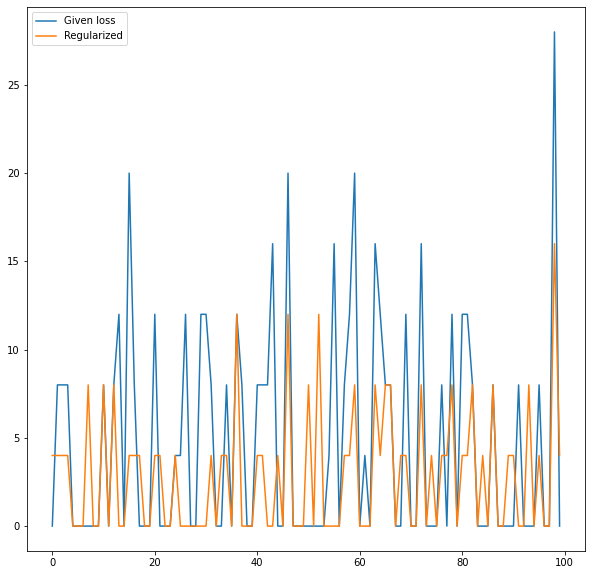

In [28]:
loss = []
reg_loss = []
print("Computing losses...")
for subset in subsets:
    preds = model.predict(subset[:, :11])
    my_preds = model2.predict(subset[:, :11])
    score = np.argmax(preds)
    best_wine = subset[score][11]
    # print("The best wine is:",best_wine)
    loss.append(svm_loss(preds, subset[:,11]))
    reg_loss.append(my_loss(my_preds, subset[:,11]))
    # print("Loss from Paper:", svm_loss(preds, subset[:,11]))
    # print("Regularized:",my_loss(my_preds, subset[:,11]))

plt.figure(figsize=(10,10))
plt.plot(loss, label="Given loss")
plt.plot(reg_loss, label="Regularized")
plt.legend()
plt.show()